In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.utils.data as td
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
data = {'fruit': [0, 1], #banana = 0 & pineapple = 1
       'shape': [1, -1],
       'texture': [1, -1],
       'weight_s': [-1, 1]}

df = pd.DataFrame(data)

print(df)

   fruit  shape  texture  weight_s
0      0      1        1        -1
1      1     -1       -1         1


In [3]:
for i in range(1, 10):
    df = df.append(df)
    
sample = df.sample(10)
sample

,fruit,shape,texture,weight_s
1,1,-1,-1,1
0,0,1,1,-1
0,0,1,1,-1
0,0,1,1,-1
0,0,1,1,-1
1,1,-1,-1,1
0,0,1,1,-1
0,0,1,1,-1
1,1,-1,-1,1
1,1,-1,-1,1


In [4]:
fruit_classes = ['banana', 'pineapple']
print(sample.columns[1:4].values, 'fruit_name')

for index, row in df.sample(10).iterrows():
    print('[', row[1], row[2],row[3], ']',fruit_classes[int(row[-4])])

['shape' 'texture' 'weight_s'] fruit_name
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana
[ -1 -1 1 ] pineapple
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana
[ 1 1 -1 ] banana


In [5]:
sensors = ['shape', 'texture', 'weight_s']
label = 'fruit'

x_train, x_test, y_train, y_test = train_test_split(df[sensors].values, df[label].values,
                                                    test_size = 0.30, random_state = 100)
print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of sensors and labels:")

for n in range(0,10):
    print(x_train[n], y_train[n], '(' + fruit_classes[y_train[n]] + ')')

Training Set: 716, Test Set: 308 

Sample of sensors and labels:
[ 1  1 -1] 0 (banana)
[ 1  1 -1] 0 (banana)
[ 1  1 -1] 0 (banana)
[ 1  1 -1] 0 (banana)
[-1 -1  1] 1 (pineapple)
[-1 -1  1] 1 (pineapple)
[ 1  1 -1] 0 (banana)
[-1 -1  1] 1 (pineapple)
[ 1  1 -1] 0 (banana)
[-1 -1  1] 1 (pineapple)


In [6]:
torch.manual_seed(0)

train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size = 20, shuffle = False, num_workers = 1)


test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size = 20, shuffle = False, num_workers = 1)

In [15]:
# Number of hidden layer nodes
hl = 8

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.sc1 = nn.Linear(len(sensors), hl)
        self.sc2 = nn.Linear(hl, hl)
        self.sc3 = nn.Linear(hl, len(fruit_classes))
    
    def forward(self, x):
        x = torch.relu(self.sc1(x))
        x = torch.relu(self.sc2(x))
        x = torch.softmax(self.sc3(x),dim = 1)
        return x

model = NN()
print(model)

NN(
  (sc1): Linear(in_features=3, out_features=8, bias=True)
  (sc2): Linear(in_features=8, out_features=8, bias=True)
  (sc3): Linear(in_features=8, out_features=2, bias=True)
)


In [16]:
def train(model, data_loader, optimizer):
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        avg_loss = train_loss / (batch+1)
        print('Training set: Average loss: {:.6f}'.format(avg_loss))
        return avg_loss

def test(model, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor

            out = model(data)

            test_loss += loss_criteria(out, target).item()

            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()

            avg_loss = test_loss/batch_count
        print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avg_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
        return avg_loss
    
loss_criteria = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer.zero_grad()

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 30
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    train_loss = train(model, train_loader, optimizer)
    test_loss = test(model, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.680166
Validation set: Average loss: 0.682769, Accuracy: 145/308 (47%)

Epoch: 2
Training set: Average loss: 0.678676
Validation set: Average loss: 0.681185, Accuracy: 145/308 (47%)

Epoch: 3
Training set: Average loss: 0.677182
Validation set: Average loss: 0.679598, Accuracy: 145/308 (47%)

Epoch: 4
Training set: Average loss: 0.675684
Validation set: Average loss: 0.678006, Accuracy: 145/308 (47%)

Epoch: 5
Training set: Average loss: 0.674182
Validation set: Average loss: 0.676411, Accuracy: 145/308 (47%)

Epoch: 6
Training set: Average loss: 0.672677
Validation set: Average loss: 0.674812, Accuracy: 145/308 (47%)

Epoch: 7
Training set: Average loss: 0.671168
Validation set: Average loss: 0.673210, Accuracy: 145/308 (47%)

Epoch: 8
Training set: Average loss: 0.669655
Validation set: Average loss: 0.671603, Accuracy: 145/308 (47%)

Epoch: 9
Training set: Average loss: 0.668138
Validation set: Average loss: 0.669991, Accuracy: 145/308 (47%)

E

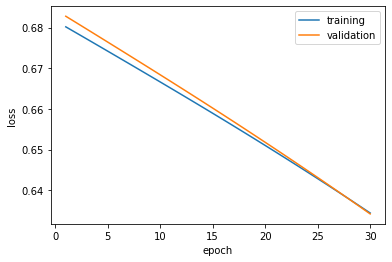

In [17]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [18]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

sc1.weight 
 [[ 0.13664758 -0.56330955 -0.16436675]
 [-0.3617827   0.5376831  -0.12683655]
 [-0.5592151  -0.06924021  0.39552948]
 [ 0.17572679  0.2082916   0.02788949]
 [ 0.19038421 -0.1655353  -0.20480728]
 [-0.5444318  -0.4397169   0.25500268]
 [-0.37389547  0.05079168  0.21632399]
 [ 0.01024914 -0.4049544   0.582766  ]]
sc1.bias 
 [-0.33572888  0.4440203  -0.42634082 -0.11314981  0.34520638 -0.23111653
  0.51721513 -0.36667785]
sc2.weight 
 [[-0.29690406 -0.1283726   0.02694837  0.35673103 -0.13986081  0.09691782
  -0.11866913 -0.10682378]
 [ 0.25996903 -0.3054427   0.06821509  0.30091444 -0.07803931  0.30454138
  -0.07837858  0.3152107 ]
 [-0.34200293 -0.02019559 -0.09197015  0.1454959   0.16725875  0.24230419
  -0.0823651  -0.04383592]
 [ 0.24211732 -0.12080649  0.28259996 -0.23540014 -0.06981719 -0.04553849
   0.13075355  0.2144349 ]
 [-0.05603954 -0.2637316   0.20632695  0.10575905  0.17508733 -0.18752858
   0.25843593  0.36596823]
 [ 0.0306783  -0.330236    0.24819091 -0.26214

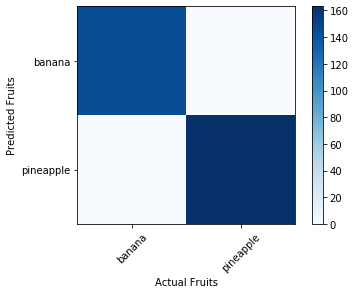

In [19]:
model.eval()

x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(fruit_classes))
plt.xticks(tick_marks, fruit_classes, rotation=45)
plt.yticks(tick_marks, fruit_classes)
plt.xlabel("Actual Fruits")
plt.ylabel("Predicted Fruits")
plt.show()